In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df_train = pd.read_csv('/content/train.csv')

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [ ]:
df_train.isnull().sum()

,0
date,0
store,0
item,0
sales,0


In [ ]:
df_train['date'] = pd.to_datetime(df_train['date'])

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


In [ ]:
df_train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [ ]:
store_id = 1
item_id = 1
df_store_item = df_train[(df_train['store'] == store_id) & (df_train['item'] == item_id)].copy()

df_store_item.sort_values('date', inplace=True)

df_store_item.set_index('date', inplace=True)

weekly_sales = df_store_item['sales'].resample('W').sum()

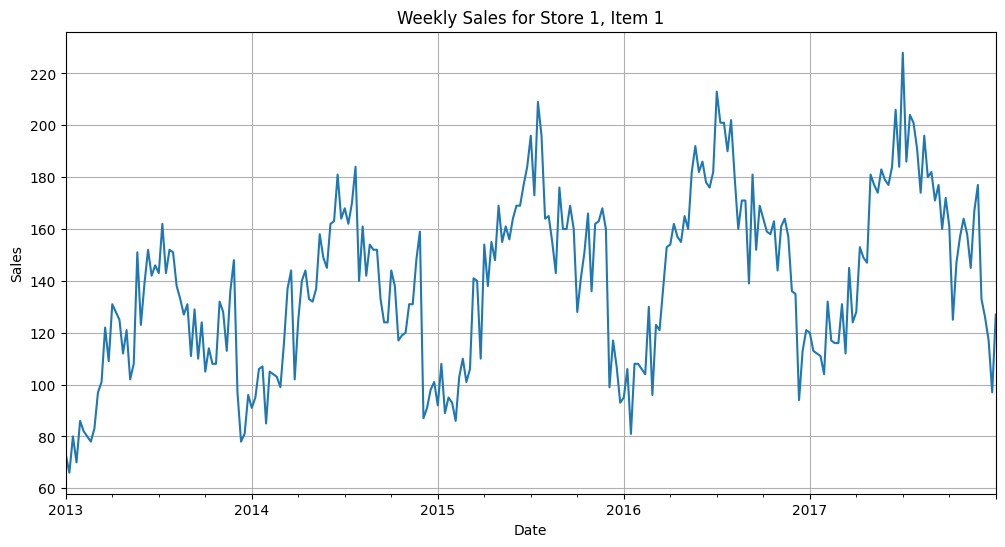

In [ ]:
plt.figure(figsize=(12,6))
weekly_sales.plot()
plt.title(f'Weekly Sales for Store {store_id}, Item {item_id}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

Seasonality: Repeating up and down pattern with each year - its a seasonal effect.    
Trend: Sales generally increase until late 2016, then fluctuate.   
Valatility: Spikes and drops, possibly due to promotions or stockouts. Seasonal product sureg or supply chain variation.

In [ ]:
from statsmodels.tsa.seasonal import STL

In [ ]:
stl = STL(weekly_sales, period=52)
res = stl.fit()

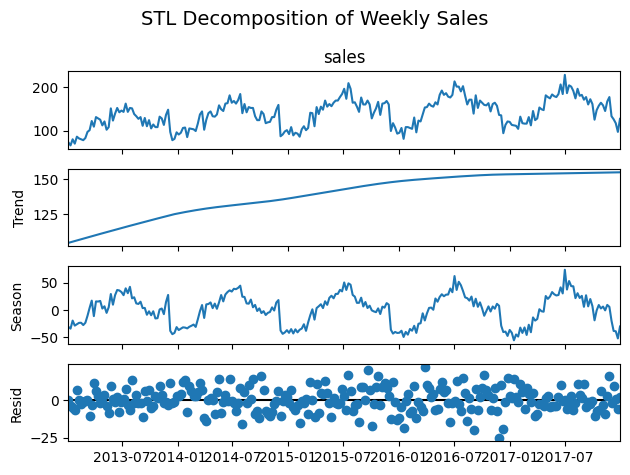

In [ ]:
res.plot()
plt.suptitle('STL Decomposition of Weekly Sales', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(weekly_sales)


In [ ]:
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
for key, value in adf_result[4].items():
    print(f'Critical Value ({key}): {value}')

ADF Statistic: -3.075336148396297
p-value: 0.028433087450215506
Critical Value (1%): -3.455952927706342
Critical Value (5%): -2.8728086526320302
Critical Value (10%): -2.572774990685656


ADF Test Interpretation:
ADF Statistic = -3.075

p-value = 0.028 < 0.05

Conclusion: Reject the null hypothesis → The series is stationary
(because the ADF statistic is lower than the 5% critical value)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

model = ARIMA(weekly_sales, order=(1, 0, 1))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  261
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1096.619
Date:                Wed, 14 May 2025   AIC                           2201.238
Time:                        07:54:04   BIC                           2215.496
Sample:                    01-06-2013   HQIC                          2206.970
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        134.0149     11.112     12.060      0.000     112.235     155.795
ar.L1          0.9526      0.021     45.066      0.000       0.911       0.994
ma.L1         -0.3844      0.063     -6.148      0.0

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(weekly_sales,
                       order=(1, 0, 1),
                       seasonal_order=(1, 1, 1, 52))
sarima_result = sarima_model.fit()

print(sarima_result.summary())

forecast_sarima = sarima_result.forecast(steps=12)



                                     SARIMAX Results                                      
Dep. Variable:                              sales   No. Observations:                  261
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 52)   Log Likelihood                -856.902
Date:                            Wed, 14 May 2025   AIC                           1723.804
Time:                                    08:05:50   BIC                           1740.516
Sample:                                01-06-2013   HQIC                          1730.561
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      2.175      0.460      0.646      -3.262       5.262
ma.L1         -0.8475      0.041   

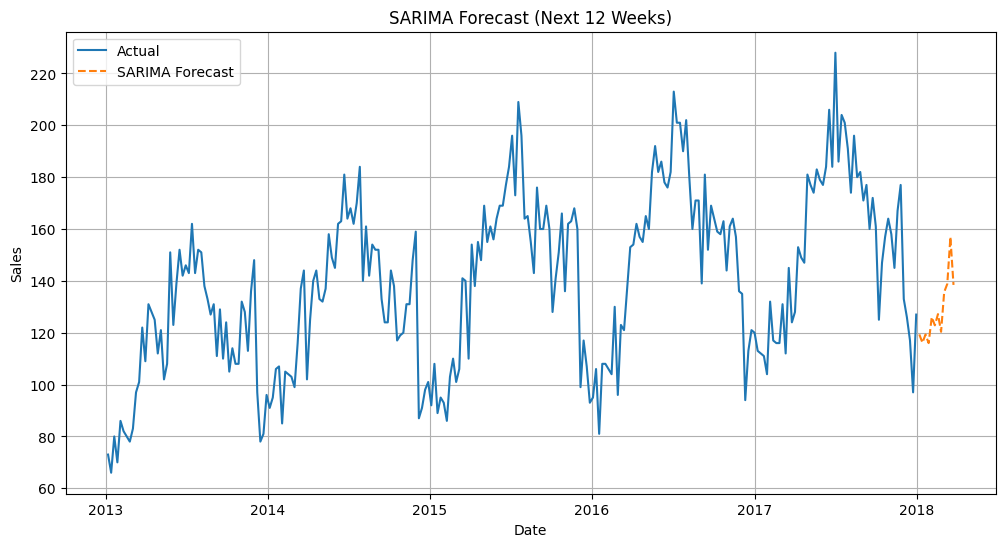

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(weekly_sales, label='Actual')
plt.plot(forecast_sarima, label='SARIMA Forecast', linestyle='--')
plt.title('SARIMA Forecast (Next 12 Weeks)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

SARIMA Model Summary – Key Takeaways.  
Metric	Meaning.   
AIC = 1723.8	Lower is better; used for model comparison.    
P-values for ma.L1 = 0.000	Indicates this term is statistically significant.    
ar.S.L52 and ma.S.L52 not significant	Seasonal AR and MA may need tuning or simplification.   
Ljung-Box p = 0.94	Residuals resemble white noise (good!).    
Jarque-Bera p = 0.70	Residuals are normally distributed (also good).

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

In [ ]:
train = weekly_sales[:-12]
test = weekly_sales[-12:]

In [ ]:
model_eval = SARIMAX(train, order = (1,0,1),seasonal_order=(1,1,1,52)).fit()
pred = model_eval.forecast(steps=12)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
mae = mean_absolute_error(test, pred)
rmse = np.sqrt(mean_squared_error(test, pred))
mape = np.mean(np.abs((test - pred) / test)) * 100

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Mean Absolute Error (MAE): 9.75
Root Mean Squared Error (RMSE): 12.07
Mean Absolute Percentage Error (MAPE): 7.39%
